# 图像增广

对训练图像进行一系列的随机变化之后，生成相似但不同的训练样本，从而扩大了训练集的规模。减少模型对某些属性的依赖，从而提高模型的泛化能力。

In [1]:
%matplotlib inline
import torch
import torchvision
from torchvision import transforms
from torch import nn
from d2l import torch as d2l
from matplotlib import pyplot as plt
from PIL import Image

ModuleNotFoundError: No module named 'matplotlib'

### 1. 常用的图像增广方法

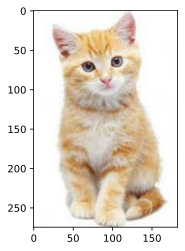

In [42]:
img = Image.open('../img/cat1.jpg')
plt.imshow(img)

In [43]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_cols * num_rows)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

#### 1.1. 翻转和裁剪

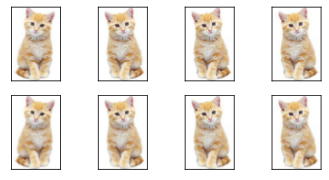

In [44]:
apply(img, transforms.RandomHorizontalFlip())

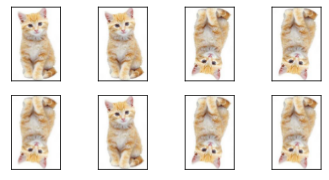

In [45]:
apply(img, transforms.RandomVerticalFlip())

在下面的代码中，我们随机裁剪一个面积为原始面积10%到100%的区域，该区域的宽高比从0.5到2之间随机取值。 然后，区域的宽度和高度都被缩放到200像素。

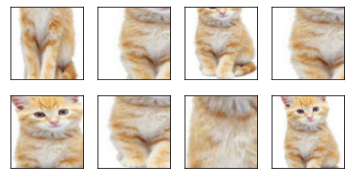

In [46]:
shape_aug = transforms.RandomResizedCrop([200, 200],
             scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)             

#### 1.2. 改变颜色

我们可以改变图像颜色的四个方面：亮度、对比度、饱和度和色调。

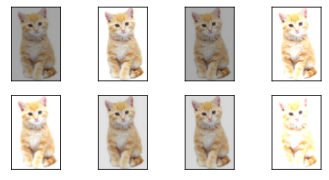

In [47]:
apply(img, transforms.ColorJitter(brightness=0.5))

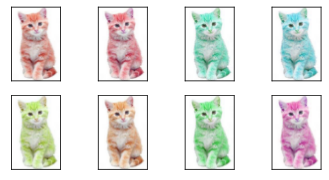

In [48]:
apply(img, transforms.ColorJitter(hue=0.5))

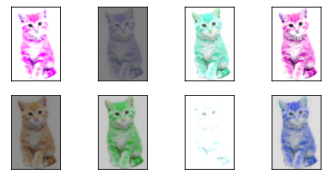

In [49]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

#### 1.3. 结合多种图像增广方法

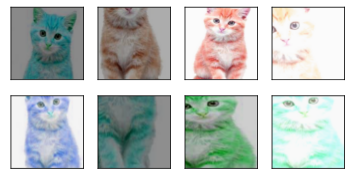

In [50]:
augs = transforms.Compose([transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

### 2. 使用图像增广进行训练

Files already downloaded and verified


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

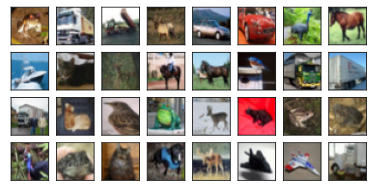

In [51]:
all_images = torchvision.datasets.CIFAR10('../data', True, download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8)

In [52]:
train_augs = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor()])
test_augs = transforms.Compose([transforms.ToTensor()])

接下来，我们定义一个辅助函数，以便于读取图像和应用图像增广。

In [53]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root='../data', train=is_train,
                        transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                    shuffle=is_train, num_workers=d2l.get_dataloader_workers())                        
    return dataloader

In [57]:
#@save
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """用多GPU进行小批量训练"""
    if isinstance(X, list):
        # 微调BERT中所需（稍后讨论）
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    """用多GPU进行模型训练"""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # 4个维度：储存训练损失，训练准确度，实例数，特点数
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

In [55]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

Files already downloaded and verified
Files already downloaded and verified


KeyboardInterrupt: 

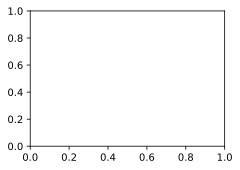

In [56]:
train_with_data_aug(train_augs, test_augs, net)